# Objective

## Problem to solve

Credit Card Fraud Detection. The objective is to accurately identify fraudulent transactions within a vast stream of legitimate ones.

Challenges:
1.  **Imbalanced Data:** Fraudulent transactions are extremely rare, making it hard for standard models to learn the "fraud" signals without bias towards the majority class.
2.  **Cost Sensitivity:** False Negatives (missing a fraud) are usually much more costly than False Positives (flagging a legit transaction as fraud).

## Dataset

- https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

The dataset contains transactions made by credit cards in September 2013 by European cardholders.

Characteristics:
*   **Volume:** ~285,000 transactions over 2 days.
*   **Imbalance:** Only 492 transactions are fraudulent (0.172%).
*   **Privacy:** Most features (V1-V28) are result of a PCA transformation to protect user confidentiality.
*   **Features:**
    *   `Time`: Seconds elapsed between each transaction and the first transaction.
    *   `Amount`: Transaction amount.
    *   `Class`: 1 (Fraud) or 0 (Legitimate).

In [1]:
from mlp_fraud import *

# Suppress TensorFlow CUDA warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set random seed for reproducibility
SEED = 42
keras.utils.set_random_seed(SEED)

2025-12-07 22:46:21.838056: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 22:46:21.873984: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-07 22:46:22.596572: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Exploratory Data Analysis

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

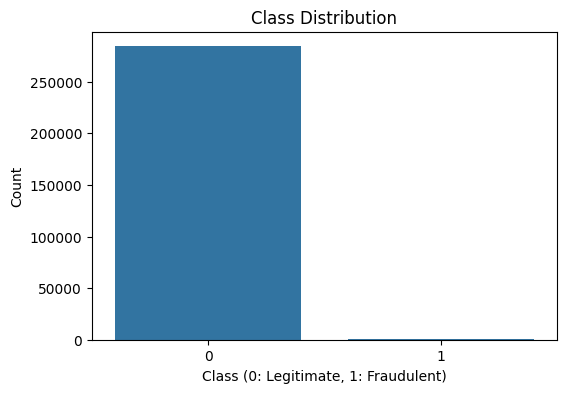

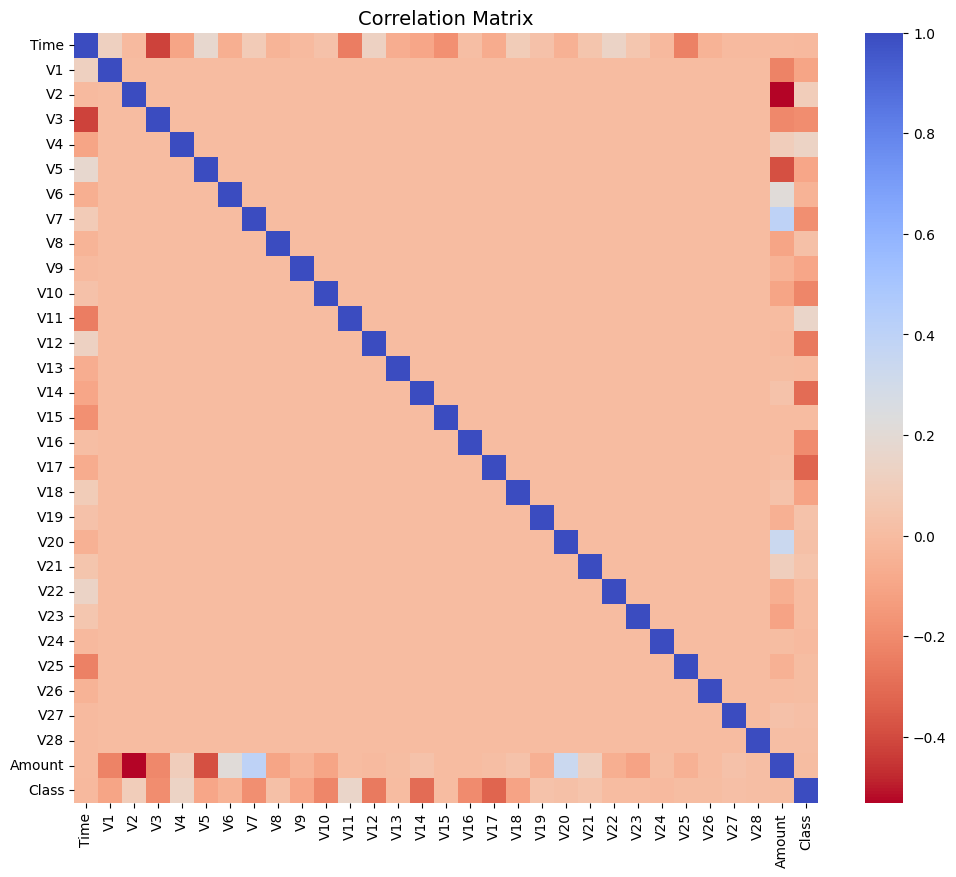

In [2]:
credit_card_df = pd.read_csv("data/mlp/raw/creditcard.csv")
print(credit_card_df.head())
print(f"Dataset shape: {credit_card_df.shape}")

check_missing_values(credit_card_df)

# Plot the `Class` distribution
target_col = 'Class'

counts = credit_card_df[target_col].value_counts()
print(f"Class counts:\n{counts}")
print(f"Fraud percentage: {counts[1] / len(credit_card_df) * 100:.4f}%")

plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=credit_card_df)
plt.title('Class Distribution')
plt.xlabel('Class (0: Legitimate, 1: Fraudulent)')
plt.ylabel('Count')
plt.show()

# Plot the Correlation Matrix
plt.figure(figsize=(12, 10))
corr = credit_card_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size': 20})
plt.title('Correlation Matrix', fontsize=14)
plt.show()

## Findings

### Class Distribution

* The dataset is very imbalanced, with just 0.1727% classified as **fraud**.

### Correlation Matrix

* The features (V1-V28) seem to have no correlation between them.
* There is no correlation between "Amount" and "Class".
* There are some correlations between the (V1-V28) features and the "Amount" and "Class", which is good as it means they could be useful for our model.


# Pre-processing

Preprocessing pipeline:

1.  **Feature Selection:** The `Time` column was dropped as it might introduce noise in this format.
2.  **Data Splitting:**
    *   The data was first split into **Train** and **Test** sets.
    *   Then split the **Train** set again into **Train** and **Validation** sets.
    *   Stratification was used to maintain the ratio of fraud cases across all splits.
3.  **Scaling:** We used `StandardScaler` to normalize the `Amount` column.
4.  **Handling Imbalance (Resampling):**
    *   We applied **SMOTE+ENN (Synthetic Minority Over-sampling Technique + Edited Nearest Neighbours)**.
    *   This hybrid approach oversamples the minority class (creating synthetic examples) and cleans the data by removing samples that are close to the decision boundary or misclassified by nearest neighbors.
    *   *Note:* Resampling was applied **only to the training data**. The validation and test sets remained in their original distribution to provide a realistic evaluation metric.

In [3]:
# Drop `Time` column
df_clean = credit_card_df.drop(columns=['Time'])

# Split the data into training and test sets using stratification.
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# Further split training data into training and validation sets (Validation remains pure/imbalanced)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=SEED)

# Scale (normalize) the `Amount` column
def scale_amount(X_train, X_val, X_test):
    scaler = StandardScaler()

    # Use .copy() to avoid SettingWithCopyWarning
    X_train = X_train.copy()
    X_val = X_val.copy()
    X_test = X_test.copy()

    # Fit on training data ONLY
    X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])

    # Transform validation and test data
    X_val['Amount'] = scaler.transform(X_val[['Amount']])
    X_test['Amount'] = scaler.transform(X_test[['Amount']])

    return X_train, X_val, X_test

X_train, X_val, X_test = scale_amount(X_train, X_val, X_test)

# Resampling using SMOTE+ENN (Only on the partial training set)
smote_enn = SMOTEENN(random_state=SEED)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)
print(f"New training counts: {y_train_res.value_counts()}")

New training counts: Class
1    181961
0    181663
Name: count, dtype: int64


# Model definition

We constructed a **Multi-Layer Perceptron (MLP)** using the Keras Sequential API.

**Architecture:**
*   **Input Layer:** Matches the dimensionality of the features.
*   **Hidden Layer 1:** 128 Neurons, ReLU activation.
    *   **Batch Normalization:** Stabilizes learning and reduces the number of epochs.
    *   **Dropout (0.x):** Randomly drops neurons during training to prevent overfitting.
*   **Hidden Layer 2:** 64 Neurons, ReLU activation.
    *   Includes Batch Normalization and Dropout.
*   **Output Layer:** 1 Neuron, Sigmoid activation.
    *   Outputs a probability score between 0 and 1 (probability of fraud).


In [4]:
input_dim = X_train_res.shape[1]

mlp_model = keras.Sequential([
    layers.InputLayer(shape=(input_dim,)),
    layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

mlp_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
    ])

mlp_model.summary()

I0000 00:00:1765169259.818767   71684 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6166 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 384 (1.50 KB)

# Training

The model was trained with the following configuration:

*   **Loss Function:** `binary_crossentropy`, standard for binary classification.
*   **Optimizer:** `Adam` with a dynamic learning rate.
*   **Callbacks:**
    *   **EarlyStopping:** Monitored validation loss to stop training when the model stopped improving (preventing overfitting).
    *   **ReduceLROnPlateau:** Reduced the learning rate when validation performance plateaued, allowing the model to fine-tune its weights.

**Observations:**
*   The model converged relatively quickly (under 20 epochs).
*   The validation metrics remain high because of the imbalance in the set where the majority of samples are non-fraudulent.

Epoch 1/50


2025-12-07 22:47:41.557192: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f3a4400ddb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-07 22:47:41.557211: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-12-07 22:47:41.587225: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-07 22:47:41.755116: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-07 22:47:41.853511: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-07 22:47:41.

 161/1421 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step - accuracy: 0.8635 - loss: 0.2986 - precision: 0.8875 - recall: 0.8345

I0000 00:00:1765169264.684011   71892 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1397/1421 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.9524 - loss: 0.1161 - precision: 0.9601 - recall: 0.9437

2025-12-07 22:47:46.222126: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-07 22:47:46.222158: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-07 22:47:46.222167: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-07 22:47:46.222178: I external/l

1421/1421 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9780 - loss: 0.0577 - precision: 0.9794 - recall: 0.9766 - val_accuracy: 0.9951 - val_loss: 0.0163 - val_precision: 0.2393 - val_recall: 0.8481 - learning_rate: 0.0010
Epoch 2/50
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9961 - loss: 0.0127 - precision: 0.9948 - recall: 0.9973 - val_accuracy: 0.9980 - val_loss: 0.0094 - val_precision: 0.4539 - val_recall: 0.8101 - learning_rate: 0.0010
Epoch 3/50
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9980 - loss: 0.0067 - precision: 0.9973 - recall: 0.9987 - val_accuracy: 0.9986 - val_loss: 0.0088 - val_precision: 0.5702 - val_recall: 0.8228 - learning_rate: 0.0010
Epoch 4/50
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9986 - loss: 0.0049 - precision: 0.9981 - recall: 0.9991 - val_accuracy: 0.9989 - val_loss: 0.0087 - val_precision: 0.6311 - val_recall: 0.8228 - learning_rate: 0.0010
Epoch 5/50
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0

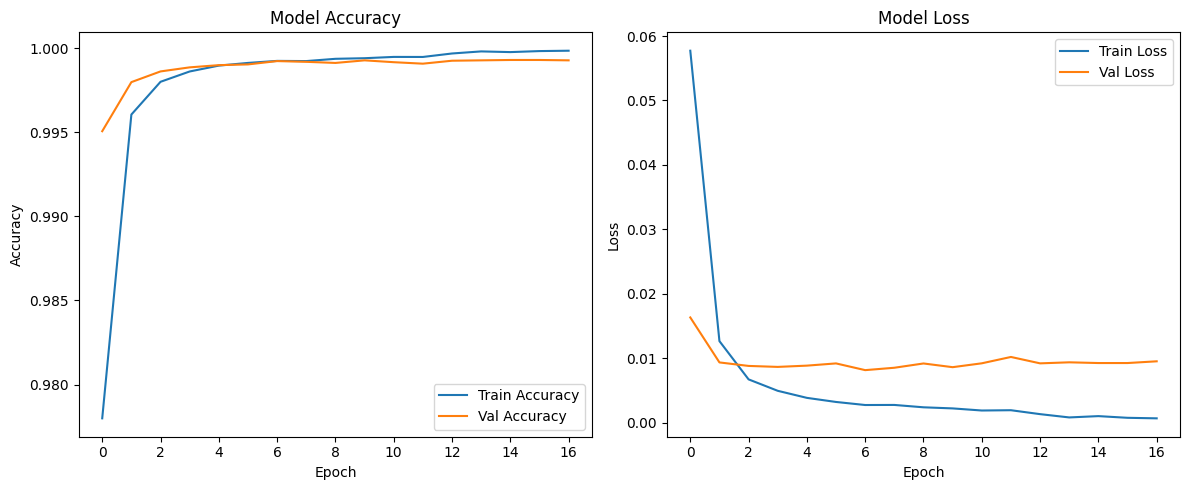

In [5]:
epochs = 50
batch_size = 256

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
]

history = mlp_model.fit(
    X_train_res, y_train_res,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

metrics = ['accuracy', 'loss']
plt.figure(figsize=(12, 5))

for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i + 1)
    plt.plot(history.history[metric], label=f'Train {metric.capitalize()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
    plt.title(f'Model {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()

# Evaluation and Results

We evaluated the model on the unseen **Test Set**.

1.  **Threshold Tuning:**
    *   Instead of the default 0.5 threshold, we calculated an **Optimal Threshold** based on the **F2-Score**.
    *   The F2-Score weighs **Recall** higher than Precision. In fraud detection, catching a fraud (Recall) is often prioritized over avoiding a false alarm (Precision), making F2 a more business-relevant metric.
2.  **Results:**
    *   The model achieved a high accuracy (near 99.9%), which is expected for this imbalanced dataset.
    *   More importantly, there is a strong F1 and F2 score on the minority class (fraud).
    *   The Confusion Matrix demonstrates very few False Negatives (Missed Frauds), which validates the effectiveness of the SMOTE+ENN resampling strategy.


Finding optimal threshold (beta=2)...


2025-12-07 22:48:14.151827: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-07 22:48:14.682309: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 24 bytes spill stores, 24 bytes spill loads



Optimal Threshold: 0.9814
Best F2 Score: 0.8300


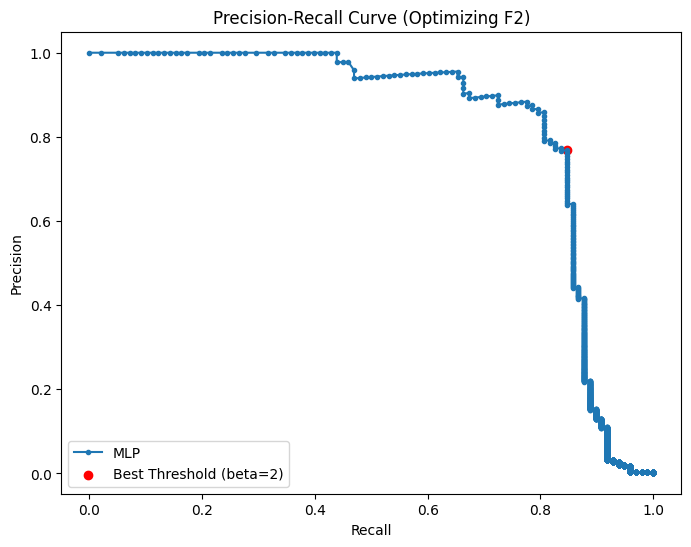

loss: 0.0067
compile_metrics: 0.9989

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.84      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962



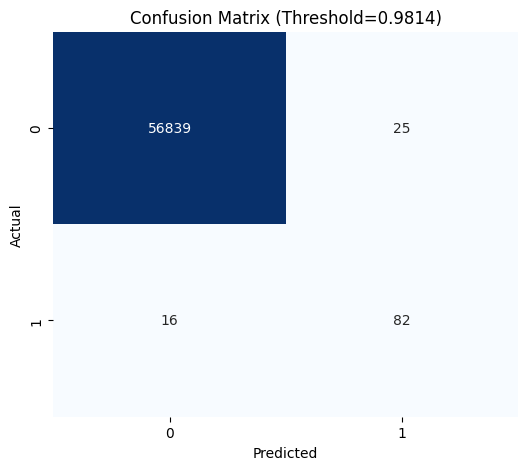

In [6]:
threshold = find_optimal_threshold(mlp_model, X_test, y_test, beta=2)

# Evaluate model
results = mlp_model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(mlp_model.metrics_names, results):
    print(f"{name}: {value:.4f}")

y_pred_prob = mlp_model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > threshold).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Threshold={threshold:.4f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Analysis and Conclusions

## Interpretation of Results
The MLP model proved to be very effective for this binary classification task after addressing the class imbalance.
- **Resampling Effectiveness:** The usage of SMOTE+ENN allowed the model to learn the minority class features, preventing the bias towards the majority class that is common in fraud detection.
- **Architecture:** A relatively simple MLP was sufficient to achieve good results.
- **Thresholding:** Optimizing the decision threshold based on the F2-Score allowed us to prioritize Recall (catching fraud) over Precision, which aligns with the business cost of missing a fraudulent transaction.

## Model Limitations
1. **False Positives:** Despite the high recall, the precision on the positive class (fraud) is not perfect. This means a number of legitimate transactions are flagged, which requires manual review or causes customer friction.

## Possible Improvements
1. **Error Analysis:** Analyze the False Positives to identify common patterns among legitimate transactions that are being misclassified.
2. **Architecture Exploration:** Experiment with a more complex architecture to see if they offer a better Precision/Recall trade-off.
